# Visualisation of LFP & Calcium traces if no subsessions

### Load LFP and packages

In [1]:
cd "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/"

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023


In [2]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
import copy
import json
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby
import sys 
import pickle
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths
from scipy import stats
import matplotlib.colors as mcolors
import warnings
from scipy import interpolate

warnings.filterwarnings("ignore")

#%matplotlib widget



def filterLFP(lfp, f_lowcut, f_hicut):
    range=f_hicut-f_lowcut
    fs = 1000
    nyq = 0.5 * fs
    N = 3 # Filtre order
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
    b, a = signal.butter(N, Wn, 'band')
    filt= signal.filtfilt(b, a, lfp)
    # Parameter and computation of CWT
    w = 100. #window size
    freq = np.linspace(f_lowcut, f_hicut, range)
    widths = w*fs / (2*freq*np.pi)
    CWT = signal.cwt(filt, signal.morlet2, widths, w=w)
    # Projection calculation
    absCWT = np.absolute(CWT)
    zabsCWT = stats.zscore(absCWT, axis=None)
    proj_CWT = np.max(zabsCWT, axis = 0)/range
    return proj_CWT


In [3]:
cd "C:/Users/Manip2/SCRIPTS/CodePythonAudrey/CodePythonAurelie/HayLabAnalysis/minian"


C:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\minian


In [4]:
from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    open_minian_mf,
    save_minian,
)

### Choose recording session

In [5]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"


# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Select session folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

Stored 'dpath' (str)


In [127]:
folder_base = Path(os.path.join(dpath, "OpenEphys"))

filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
All0 = np.load(filename2, mmap_mode= 'r')
All = All0*0.195 # *0.195 to convert in µV

ScoringFile = folder_base / f'ScoredSleep_AH.npy'
ScoringFile = folder_base / f'ScoredSleep_AB.npy'

SleepScoredTS=np.load(ScoringFile)

mfile = open(Path(dpath).parent / f'mappingsAB_ALL.pkl', 'rb') if 'CGP' not in dpath else open(Path(dpath).parent.parent / f'mappingsAB_ALL.pkl', 'rb')
mapping = pickle.load(mfile)
B = mapping['session']    

Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 
allchannels = pd.read_excel(Channels)

path_obj=Path(folder_base.parent)
if len(path_obj.parts)==10: # Not a DrugExperiment with Subsessions       
    mice= path_obj.parents[1].name
elif len(path_obj.parts)==9: # Not a DrugExperiment with No Subsessions
    mice= path_obj.parents[0].name
elif len(path_obj.parts)==11: # DrugExperiment with Subsessions
    mice = path_obj.parents[2].name

StampsFile = folder_base.parent / f'SynchroFileCorrect.xlsx'
Stamps= pd.read_excel(StampsFile)
StartTime = list(Stamps[0])[0]
minian_freq=list(Stamps[0])[2]   

try:
    minian_ds =  open_minian(folder_base.parent /f'V4_Miniscope'/ f'minian')
    subsession=0
except: 
    minian_ds = open_minian_mf(folder_base.parent, ["session"], pattern="minian")
    subsession=1
    
CA = minian_ds['C'] # calcium traces 
SP = minian_ds['S'] # estimated spikes

coord = CA.coords['session'].values
loop=coord if subsession else [coord]
freqLFP=1000


TSminiscopePath=folder_base.parent/ f'V4_Miniscope/timeStamps.csv'
TSminiscope=pd.read_csv(TSminiscopePath)
tsmini=TSminiscope['Time Stamp (ms)']



In [133]:
AllCalcium=pd.DataFrame()
AllSpike=pd.DataFrame()

for s,subsessionName in enumerate(loop): #number of subsession
    indexMappList=B[subsessionName] if subsession else B[folder_base.parts[-2]]
    folder_mini=folder_base.parent/ f'V4_Miniscope'/subsessionName if subsession else folder_base.parent/ f'V4_Miniscope'
    
    try:
        TodropFile = folder_mini / f'minian/TodropFileAB.json'
        with open(TodropFile, 'r') as f:
            unit_to_drop = json.load(f)
    except:
        TodropFile = folder_mini / f'minian/TodropFile.json'
        with open(TodropFile, 'r') as f:
            unit_to_drop = json.load(f)

    CalciumSub1 = CA[s] if subsession else CA
    SpikeSub1 = SP[s] if subsession else SP

    CalciumSub = pd.DataFrame(CalciumSub1, index=CalciumSub1['unit_id'])
    recdur = CalciumSub.dropna(axis=1, how='all').shape[1] #cause Nans were added to match the different subsessions video sizes
    CalciumSub = CalciumSub.dropna(axis=1, how='all') #cause Nans were added to match the different number of units detected per subsessions 
    CalciumSub = CalciumSub.dropna(axis=0, how='all') #cause Nans were added to match the different number of units detected per subsessions 
    SpikeSub = pd.DataFrame(SpikeSub1, index=CalciumSub1['unit_id'])
    SpikeSub = SpikeSub.dropna(axis=0, how='all') #cause Nans were added to match the different number of units detected per subsessions 
    SpikeSub = SpikeSub.dropna(axis=1, how='all') #cause Nans were added to match the different subsessions video sizes

    for u in unit_to_drop: 
        CalciumSub=CalciumSub.drop(index=u) if u in CalciumSub.index else CalciumSub
        SpikeSub=SpikeSub.drop(index=u) if u in SpikeSub.index else SpikeSub

    kept_uniq_unit_List=[]
    for unit in CalciumSub.index:
        indexMapp = np.where(indexMappList == unit)[0]
        kept_uniq_unit_List.append(str(indexMapp))

    CalciumSub.index=[f"{mice}{str(i).replace('[','').replace(']','')}" for i in kept_uniq_unit_List]
    
    kept_uniq_unit_List=[]
    for unit in SpikeSub.index:
        indexMapp = np.where(indexMappList == unit)[0]
        kept_uniq_unit_List.append(str(indexMapp))

    SpikeSub.index=[f"{mice}{str(i).replace('[','').replace(']','')}" for i in kept_uniq_unit_List]

    CalciumSub=CalciumSub[CalciumSub.index!=mice] #remove nr not in the cross registration
    SpikeSub=SpikeSub[SpikeSub.index!=mice]

    print(CalciumSub.shape)

    AllCalcium=pd.concat([AllCalcium, CalciumSub.T], axis=0, ignore_index=True) #if CalciumSub.shape[0] else pd.concat([AllCalcium, pd.DataFrame(np.full((1, CalciumSub1.shape[1]), np.nan))], ignore_index=True)
    AllSpike=pd.concat([AllSpike, SpikeSub.T], axis=0, ignore_index=True)# if CalciumSub.shape[0] else pd.concat([AllSpike, pd.DataFrame(np.full((1, CalciumSub1.shape[1]), np.nan))], ignore_index=True)

unaligned_Calcium=AllCalcium.T.copy()
unaligned_Spike=AllSpike.T.copy()
print(np.shape(unaligned_Calcium), 'unaligned')

# Realigned to the real minian frequency and the timestamps 
timestamps =  np.array(tsmini)/freqLFP
x_values = unaligned_Calcium  # Each row is a Cell, each column corresponds to a timestamp
sample_rate = minian_freq  # Hz
new_timestamps= np.arange(timestamps[0], timestamps[-1], 1/sample_rate)
Calcium = pd.DataFrame(index=x_values.index, columns=new_timestamps)
for cell in x_values.index:
    interpolator = interpolate.interp1d(timestamps, x_values.loc[cell], kind='linear')
    Calcium.loc[cell] = interpolator(new_timestamps)

x_values = unaligned_Spike  # Each row is a cell, each column corresponds to a timestamp
new_timestamps= np.arange(timestamps[0], timestamps[-1], 1/sample_rate)
Spike = pd.DataFrame(index=x_values.index, columns=new_timestamps)
for cell in x_values.index:
    interpolator = interpolate.interp1d(timestamps, x_values.loc[cell], kind='linear')
    Spike.loc[cell] = interpolator(new_timestamps)
print(np.shape(Calcium), 'aligned')
      

#LFPs 
PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
CA1ch1=int(allchannels[mice][2].split(',')[0])
CA1ch2=int(allchannels[mice][2].split(',')[1])
S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])
EMGch1=int(allchannels[mice][3])

PFC  =  All[:, PFCch1]-All[:, PFCch2] 
CA1  =  All[:, CA1ch1]-All[:, CA1ch2]
S1  =  All[:, S1ch1]-All[:, S1ch2]
EMG  =  All[:, EMGch1] 

# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS) - 1, len(SleepScoredTS))
new_indices = np.linspace(0, len(SleepScoredTS) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS, kind='zero')
SleepScoredTS_upscaled = interpolated_func(new_indices)
SleepScoredTS_upscaled = np.round(SleepScoredTS_upscaled * 2) / 2

(5, 53670)
(5, 53670) unaligned
(5, 54070) aligned


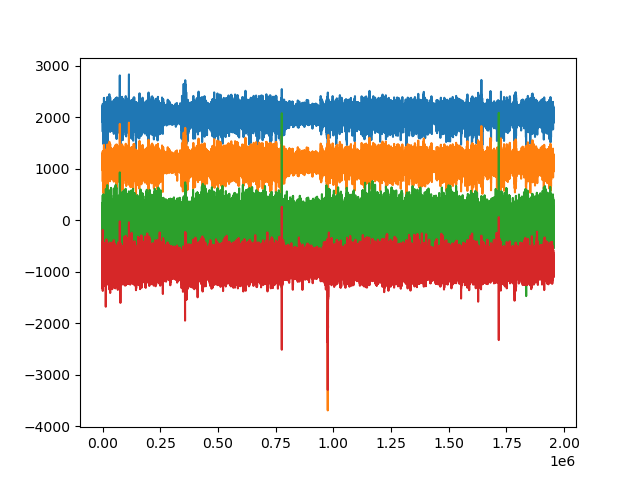

In [184]:
plt.close()
plt.plot(All[:, PFCch1]+2000)
plt.plot(All[:, PFCch2]+1000)
plt.plot(All[:, CA1ch1])
plt.plot(All[:, CA1ch2]-1000)
plt.show()

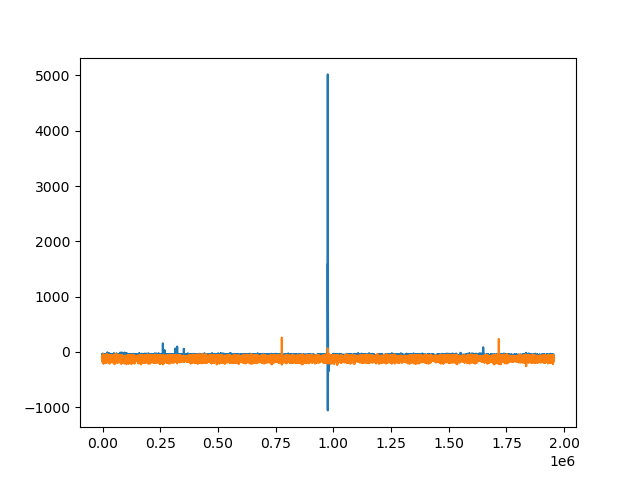

In [187]:
plt.close()
plt.plot(PFC)
plt.plot(CA1/10-100)
plt.show()

In [13]:
if sum(['CGP' in i for i in folder_base.parts])>1:
    pL1="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-10-03_17_36_46_AB_newScor_CGP/CGP/All/L1_VigSt_nAUC.xlsx"
    pL2="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-10-03_17_36_46_AB_newScor_CGP/CGP/All/L2&3_VigSt_nAUC.xlsx"
else:
    pL1="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-10-08_17_14_52_AB_newScor/Baseline/All/L1_VigSt_nAUC.xlsx"
    pL2="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-10-08_17_14_52_AB_newScor/Baseline/All/L2&3_VigSt_nAUC.xlsx"

MiceListL2=['Purple', 'ThreeColDotsOK', 'ThreeBlueCrossesOK']
p=pL2 if sum([i in dpath for i in MiceListL2]) else pL1

data=pd.read_excel(p)
d=pd.DataFrame()
d['Unit_ID']=data['Unit_ID']
d['RatioNREM_REM']=data['RatioNREM_REM']
bool=[i in Calcium.index for i in d['Unit_ID']]
len(d['Unit_ID'][bool])
d['Unit_ID'][bool]
db=d[bool]
db.index=db['Unit_ID']
dba=db['RatioNREM_REM']
SI=[dba[i] for i in Calcium.index]
SI=np.round(SI,2)
df=pd.DataFrame(data={'SI':SI}, index=Calcium.index)
df=df.sort_values(by='SI')
name=[f'{df["SI"][i]}_{i}' for i in df.index]
Calcium_sorted = Calcium.reindex(df.index)


### Load detected oscillations

In [14]:
# SWR     
OldSWSdetection=folder_base / f'SWRproperties.csv'
SWR_prop = pd.read_csv(OldSWSdetection, index_col=0)         
try: 
    SWR_prop['toKeep'] = SWR_prop['toKeep'].astype(str)
    SWR_prop  = SWR_prop[SWR_prop['toKeep'].isin(['VRAI', 'True'])]        
except: None
SWR_peak = np.transpose(SWR_prop['peak time'].astype(int))
SWR_start = np.transpose(SWR_prop['start time'].astype(int))
SWR_end = np.transpose(SWR_prop['end time'].astype(int))

# Spindles
Spdldetection=folder_base / f'Spindleproperties_S1&PFC.csv'
Spdl_prop = pd.read_csv(Spdldetection, index_col=0)  
Spdl_prop['toKeep'] = Spdl_prop['toKeep'].astype(str)
Spdl_prop  = Spdl_prop[Spdl_prop['toKeep'].isin(['VRAI', 'True'])]   

S1Spdl_prop= Spdl_prop[Spdl_prop['CTX']=='S1']
S1spdl_peak = np.transpose(S1Spdl_prop['peak time'].astype(int))
S1spdl_start = np.transpose(S1Spdl_prop['start time'].astype(int))
S1spdl_end = np.transpose(S1Spdl_prop['end time'].astype(int))

PFCSpdl_prop= Spdl_prop[Spdl_prop['CTX']=='PFC']
PFCspdl_peak = np.transpose(PFCSpdl_prop['peak time'].astype(int))
PFCspdl_start = np.transpose(PFCSpdl_prop['start time'].astype(int))
PFCspdl_end = np.transpose(PFCSpdl_prop['end time'].astype(int))

GlobalSpdl_prop= Spdl_prop[Spdl_prop['CTX']=='S1PFC']
GBLspdl_peak = np.transpose(GlobalSpdl_prop['peak time'].astype(int))
GBLspdl_start = np.transpose(GlobalSpdl_prop['start time'].astype(int))
GBLspdl_end = np.transpose(GlobalSpdl_prop['end time'].astype(int))

# Down States
DSdetection=folder_base / f'DownStatesproperties_S1&PFC.csv'
DS_prop = pd.read_csv(DSdetection, index_col=0)  
DS_prop['toKeep'] = DS_prop['toKeep'].astype(str)
DS_prop  = DS_prop[DS_prop['toKeep'].isin(['VRAI', 'True'])]   

S1DS_prop= DS_prop[DS_prop['CTX']=='S1']
S1DS_peak = np.transpose(S1DS_prop['peak time'].astype(int))
S1DS_start = np.transpose(S1DS_prop['start time'].astype(int))
S1DS_end = np.transpose(S1DS_prop['end time'].astype(int))

PFCDS_prop= DS_prop[DS_prop['CTX']=='PFC']
PFCDS_peak = np.transpose(PFCDS_prop['peak time'].astype(int))
PFCDS_start = np.transpose(PFCDS_prop['start time'].astype(int))
PFCDS_end = np.transpose(PFCDS_prop['end time'].astype(int))

GlobalDS_prop= DS_prop[DS_prop['CTX']=='S1PFC']
GBLDS_peak = np.transpose(GlobalDS_prop['peak time'].astype(int))
GBLDS_start = np.transpose(GlobalDS_prop['start time'].astype(int))
GBLDS_end = np.transpose(GlobalDS_prop['end time'].astype(int))




### EphyViewer = LFPs, Calcium traces, Spikes

In [123]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer
from ephyviewer import InMemoryAnalogSignalSource
from ephyviewer import InMemorySpikeSource


app = mkQApp()
win = MainViewer(debug=True, show_auto_scale=True)

# LFPs

sample_rate = freqLFP
t_start = 0.
#scatter_indexes = {0: PFCspdl_start, 1: PFCspdl_end, 2: S1spdl_start, 3: S1spdl_end, 4: SWR_start, 5: SWR_end}
scatter_indexes = {0: PFCspdl_start, 1: PFCspdl_end, 2: S1spdl_start, 3: S1spdl_end, 4: GBLspdl_start, 5: GBLspdl_end, 6: SWR_start, 7: SWR_end}

#scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [2], 5: [2]}
scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [0,1], 5: [0,1], 6: [2], 7: [2]}

combined = np.stack([(S1)/2, (PFC)*3, (CA1)/5, (EMG)/2], axis = 1)
#source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#FFFFFF', 5: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#BBBBBB', 5: '#555555', 6: '#FFFFFF', 7: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])

#source =InMemoryAnalogSignalSource(combined, sample_rate, t_start, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])
view1 = TraceViewer(source=source)

view1.params['display_labels'] = True
view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()
view1.by_channel_params['ch0', 'color'] = '#88FF88' #FF0000 red, #00FF00 green, and #0000FF blue
view1.by_channel_params['ch1', 'color'] = '#8888FF'
view1.by_channel_params['ch2', 'color'] = '#FF8888'
view1.by_channel_params['ch3', 'color'] = '#FFFFFF'

# Calcium traces 
#view2 = TraceViewer.from_numpy(zscore(np.array(Calcium_sorted.T), nan_policy='omit'), float(30), round(StartTime,2), 'Calcium Traces',channel_names=name)
view2 = TraceViewer.from_numpy((np.array(Calcium_sorted.T)), float(minian_freq), round(StartTime,2), 'Calcium Traces',channel_names=name)
#view2 = TraceViewer.from_numpy(np.array(Calcium.loc['ThreeColDotsOK130']).T, float(minian_freq), round(StartTime,2), 'Calcium Traces',channel_names=['ThreeColDotsOK130'])
view2.params['scale_mode'] = 'same_for_all'
view2.auto_scale()
view2.params['display_labels'] = True


# Spike traces 
all_spikes = []
for c,row in enumerate(np.array(Spike)):
    peaks, _ = find_peaks(row)#, height=np.nanstd(row)/5)
    all_spikes.append({ 'time':(peaks/minian_freq)+round(StartTime,2), 'name':Calcium.index[c] })
source = InMemorySpikeSource(all_spikes=all_spikes)
view3 = ephyviewer.SpikeTrainViewer(source=source, name='spikes')


# Sleep Scoring

array=SleepScoredTS_upscaled
#SleepScoredTS_upscaled[SleepScoredTS_upscaled == 0.5] = 0
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'NREM', 0.5: 'NREM', 1: 'REM', 1.5: 'Wake'}
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'REM', 'Wake']
states=['NREM', 'N2', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view4= EpochViewer(source=source_ep, name='Scoring')

view4.by_channel_params['ch0', 'color'] = '#5555FF'
view4.by_channel_params['ch1', 'color'] = 'cyan'
view4.by_channel_params['ch2', 'color'] = '#00AA00'
view4.by_channel_params['ch3', 'color'] = '#FFFFFF'
#add them to mainwindow

win.add_view(view1)
win.add_view(view4)
win.add_view(view2)
win.add_view(view3)

#Run

win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for Calcium Traces 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring 0.0 s
refresh duration for Calcium Traces 0.0 s
refresh duration for spikes 0.0 s
save_all_settings


0

### EphyViewer =  LFPs, Calcium traces, FFT, 

In [11]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer
from ephyviewer import InMemoryAnalogSignalSource
from ephyviewer import InMemorySpikeSource

app = mkQApp()
win = MainViewer(debug=True, show_auto_scale=True)

# LFPs

sample_rate = freqLFP
t_start = 0.
scatter_indexes = {0: PFCspdl_start, 1: PFCspdl_end, 2: S1spdl_start, 3: S1spdl_end, 4: SWR_start, 5: SWR_end}
scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [2], 5: [2]}
combined = np.stack([(S1), (PFC), (CA1)/5, (EMG)/5], axis = 1)
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#FFFFFF', 5: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])

view1 = TraceViewer(source=source)

view1.params['display_labels'] = True
view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()
view1.by_channel_params['ch0', 'color'] = '#88FF88' #FF0000 red, #00FF00 green, and #0000FF blue
view1.by_channel_params['ch1', 'color'] = '#8888FF'
view1.by_channel_params['ch2', 'color'] = '#FF8888'
view1.by_channel_params['ch3', 'color'] = '#FFFFFF'

# FFT
view3 = TimeFreqViewer(source=source, name='FFT')

view3.params['show_axis'] = True
view3.params['timefreq', 'f_start'] = 1
view3.params['timefreq', 'f_stop'] = 30
view3.params['timefreq', 'deltafreq'] = 1 #interval in Hz

view3.by_channel_params['ch0', 'clim'] = 300
view3.by_channel_params['ch1', 'clim'] = 300
view3.by_channel_params['ch2', 'clim'] = 300
view3.by_channel_params['ch0', 'visible'] = True
view3.by_channel_params['ch1', 'visible'] = True
view3.by_channel_params['ch2', 'visible'] = False
view3.by_channel_params['ch3', 'visible'] = False


# Spike traces 
"""
# Spike traces 
all_spikes = []
for c,row in enumerate(np.array(Spike)):
    peaks, _ = find_peaks(row)#, height=np.nanstd(row)/5)
    all_spikes.append({ 'time':(peaks/minian_freq)+round(StartTime,2), 'name':Calcium.index[c] })
source = InMemorySpikeSource(all_spikes=all_spikes)
view2 = ephyviewer.SpikeTrainViewer(source=source, name='spikes')
"""
# Calcium traces 
view2 = TraceViewer.from_numpy((np.array(Calcium.T)), float(minian_freq), round(StartTime,2), 'Calcium Traces',channel_names=name)
view2.params['scale_mode'] = 'same_for_all'
view2.auto_scale()
view2.params['display_labels'] = True

# Sleep Scoring

array=SleepScoredTS_upscaled
#SleepScoredTS_upscaled[SleepScoredTS_upscaled == 0.5] = 0
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'NREM', 0.5: 'NREM', 1: 'REM', 1.5: 'Wake'}
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'REM', 'Wake']
states=['NREM', 'N2', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view4= EpochViewer(source=source_ep, name='Scoring')

view4.by_channel_params['ch0', 'color'] = '#5555FF'
view4.by_channel_params['ch1', 'color'] = 'cyan'
view4.by_channel_params['ch2', 'color'] = '#00AA00'
view4.by_channel_params['ch3', 'color'] = '#FFFFFF'
#add them to mainwindow


# Add them to mainwindow

win.add_view(view1)
win.add_view(view2)
win.add_view(view3)
win.add_view(view4)

#Run

win.show()
app.exec_()

debug True
QT_MODE PyQt5


### Create figures 

In [134]:
beg=150 #in sec
fin=950

begCa=round((beg-StartTime)*minian_freq)
finCa=round((fin-StartTime)*minian_freq)

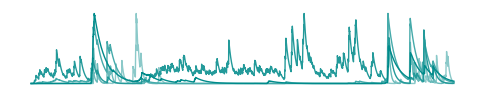

In [16]:
plt.close()
#A=Calcium[Calcium.columns[:17000]]
A=copy.deepcopy(Calcium[Calcium.columns[begCa:finCa]])
A = A.iloc[::] if sum([i in dpath for i in MiceListL2]) else A#.iloc[1::2] #A.iloc[3::3]
A = A.dropna()
#A= A.apply(zscore, axis=1)
A = A.div(A.max(axis=1), axis=0)
num_lines = A.shape[0]
# Create a colormap
cmap = plt.get_cmap('viridis')
cmap = sns.light_palette("black", as_cmap=True) if sum([i in dpath for i in MiceListL2]) else sns.light_palette("#008B8B", as_cmap=True)
# Normalize line indices to colormap range
colors = cmap(np.linspace(0,.8, num_lines)) if sum([i in dpath for i in MiceListL2]) else cmap(np.linspace(0.4, 1, num_lines))
# Plot each line with its corresponding color
plt.figure(figsize=(6, 1))
for i in range(num_lines):
    line_data = A.iloc[i]
    plt.plot(A.columns, line_data, color=colors[i], linewidth=1)  # Change '1.5' to adjust the gap
plt.axis('off')  # Hides the axis lines and labels
plt.xticks([])   # Hides the x-axis ticks
plt.yticks([]) 
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_line_2Catraces_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True) 
plt.show()

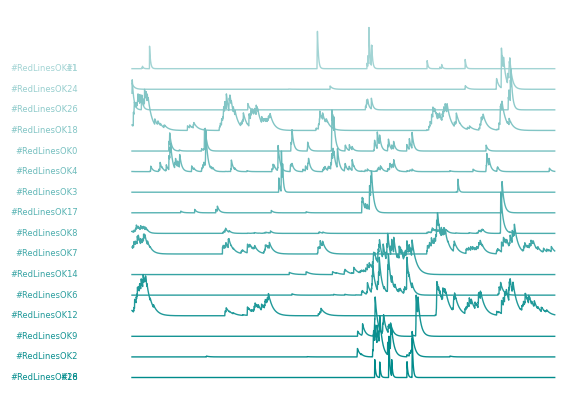

In [14]:
plt.close()
#A=Calcium[Calcium.columns[:17000]]
A=copy.deepcopy(Calcium_sorted[Calcium_sorted.columns[begCa:finCa]])
A=copy.deepcopy(Calcium[Calcium.columns[begCa:finCa]])
A = A.loc[::] if sum([i in dpath for i in MiceListL2]) else A#.iloc[1::2] #A.iloc[3::3]
A = A.dropna()
#A= A.apply(zscore, axis=1)
A = A.div(A.max(axis=1), axis=0)*2
A = A.dropna()
num_lines = A.shape[0]
# Create a colormap
cmap = plt.get_cmap('viridis')
cmap = sns.light_palette("black", as_cmap=True) if sum([i in dpath for i in MiceListL2]) else sns.light_palette("#008B8B", as_cmap=True)
# Normalize line indices to colormap range
colors = cmap(np.linspace(0.2, .9, num_lines)) if sum([i in dpath for i in MiceListL2]) else cmap(np.linspace(0.3, 1, num_lines))
# Plot each line with its corresponding color
plt.figure(figsize=(6, 5))
plt.text(A.columns[0] - 100,0, f'#1', color=colors[0], 
            ha='right', va='center', fontsize=6)  
for i in range(num_lines):
    line_data = A.iloc[i] - i * 1
    plt.plot(A.columns, line_data, color=colors[i], linewidth=1)  # Change '1.5' to adjust the gap
    # Add a label slightly to the left of each line
    plt.text(A.columns[0] - 100, min(line_data), f'#{A.index[i]}', color=colors[i], 
        ha='right', va='center', fontsize=6)  
plt.text(A.columns[0] - 100, min(line_data), f'#{i+1}', color=colors[i], 
        ha='right', va='center', fontsize=6)  
plt.axis('off')  # Hides the axis lines and labels
plt.xticks([])   # Hides the x-axis ticks
plt.yticks([])  
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_line_2Catraces_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

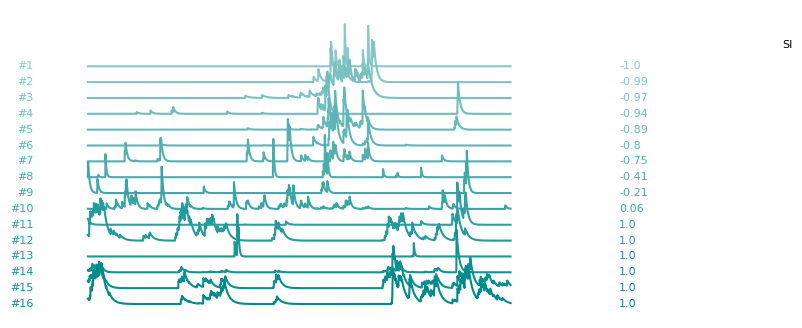

In [15]:
plt.close()
#A=Calcium[Calcium.columns[:17000]]
A=copy.deepcopy(Calcium_sorted[Calcium_sorted.columns[begCa:finCa]])
A = A.iloc[::] if sum([i in dpath for i in MiceListL2]) else A.iloc[::]
#first_half_selected = A.iloc[::]
#second_half = A.iloc[:]
#A = pd.concat([first_half_selected, second_half])
A = A.dropna()
#A= A.apply(zscore, axis=1)
A = A.div(A.max(axis=1), axis=0)*4
df=pd.DataFrame(data={'SI':SI}, index=Calcium.index)
df=df.sort_values(by='SI')
name=[f'{df["SI"][i]}_{i}' for i in df.index]
Calcium_sorted = Calcium.reindex(df.index)
SIindex=[df['SI'][i] for i in A.index]
num_lines = A.shape[0]
# Create a colormap
cmap = plt.get_cmap('viridis')
cmap = sns.light_palette("black", as_cmap=True) if sum([i in dpath for i in MiceListL2]) else sns.light_palette("#008B8B", as_cmap=True)
# Normalize line indices to colormap range
colors = cmap(np.linspace(0.4, 1, num_lines)) if sum([i in dpath for i in MiceListL2]) else cmap(np.linspace(0.4, 1, num_lines))
# Plot each line with its corresponding color
plt.figure(figsize=(6, 4))
plt.text(A.columns[-1] + 500, 2, 'SI', color='black', 
            ha='left', va='center', fontsize=8)    
"""
plt.text(A.columns[-1] + 1700,-5, 'REM cells', color='black', 
            ha='left', va='center', fontsize=8, rotation=-90)  
plt.text(A.columns[-1] + 1700, -24, 'NREM cells', color='black', 
            ha='left', va='center', fontsize=8, rotation=-90) 
"""  
for i in range(num_lines):
    line_data = A.iloc[i] - i * 1.5
    plt.plot(A.columns, line_data, color=colors[i])  # Change '1.5' to adjust the gap
    label = SIindex[i]
    # Add a label slightly to the left of each line
    plt.text(A.columns[0] - 100, min(line_data), f'#{i+1}', color=colors[i], 
            ha='right', va='center', fontsize=8)   
    plt.text(A.columns[-1] + 200, min(line_data), label, color=colors[i], 
            ha='left', va='center', fontsize=8)     
plt.axis('off')  # Hides the axis lines and labels
plt.xticks([])   # Hides the x-axis ticks
plt.yticks([])  
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_line_2Catraces_SI{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

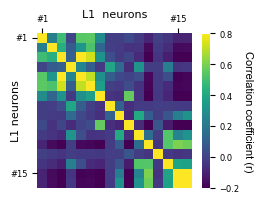

In [16]:
plt.close()
VMAX=.8
CaCorrMatrix=[]
CaCorrMatrix = pd.DataFrame(columns=[f'#{i}' for i in range(len(A))], index=[f'#{i}' for i in range(len(A))])
for unit in range(len(A)): 
    Carray_unit =A.iloc[unit]
    for unit2 in range(len(A)):
        Carray_unit2 =A.iloc[unit2]
        indexMapp =unit
        indexMapp2 = unit2                            
        corr_matrix = np.corrcoef(Carray_unit.astype(float), Carray_unit2.astype(float))
        CaCorrMatrix[f'#{indexMapp}'][f'#{indexMapp2}']={1: 0.99999, -1: -0.99999}.get(np.round(corr_matrix[0, 1],5), np.round(corr_matrix[0, 1],5))
    
df = CaCorrMatrix.apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(2.5, 2.5))
ax = sns.heatmap(df, square=True, vmin=-.2 , vmax=VMAX , cmap='viridis',
                                  cbar_kws={'shrink': 0.8, 'aspect': 20})
# Set only the first and last ticks for x and y axes
# Get the number of ticks
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticks([x_ticks[0], x_ticks[-1]])
ax.set_yticks([y_ticks[0], y_ticks[-1]])

# Optionally, set the labels for these ticks if needed
ax.set_xticklabels([f'#{int(x_ticks[0])+1}', f'#{int(x_ticks[-1])+1}'],size=6)
ax.set_yticklabels([f'#{int(y_ticks[0])+1}', f'#{int(y_ticks[-1])+1}'],size=6)

# Optionally, add labels for the axes if needed
ax.set_xlabel('L2/3  neurons', labelpad=-2,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_xlabel('L1  neurons', labelpad=-2,size=8)
ax.set_ylabel('L2/3 neurons', labelpad=-8,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_ylabel('L1 neurons', labelpad=-8,size=8)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust the font size here
cbar.set_label('Correlation coefficient (r)', fontsize=8, font='Arial', rotation=-90, labelpad=10)
ax.xaxis.set_ticks_position('top')  # Move ticks to the top
ax.xaxis.set_label_position('top')  # Move label to the top
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_2line_{beg}to{fin}s_heatmap.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

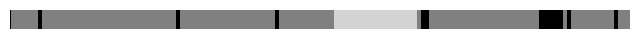

In [17]:
# Define a custom colormap with 3 shades of grey

#SleepScoredTS_upscaledCa[SleepScoredTS_upscaledCa==0.5]=0
colors = [ 'grey', 'lightgrey', 'black']  # Light grey, medium grey, dark grey
#colors = [ 'steelblue', 'lightskyblue', 'lightgrey', 'black']  # Light grey, medium grey, dark grey

cmap = mcolors.ListedColormap(colors)
# Define boundaries for the color bar
bounds = [0, 1, 1.5,2]
#bounds = [0, 0.5, 1, 1.5, 2]

norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(colors))
df = pd.DataFrame(SleepScoredTS_upscaled[beg*freqLFP:fin*freqLFP], columns=['Value']) #df = pd.DataFrame(SleepScoredTS_upscaledCa2[begCa:finCa], columns=['Value'])
# Plot the heatmap with the custom colormap
plt.figure(figsize=(8, .25))
heatmap = sns.heatmap(df.T, cmap=cmap, norm=norm, fmt="d")

# Customize color bar to show categories
cbar = heatmap.collections[0].colorbar
cbar.remove()
plt.xticks([])
plt.yticks([])
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_{beg}to{fin}s_2line_Hypno.png', format='png', bbox_inches='tight', pad_inches=0)
plt.show()

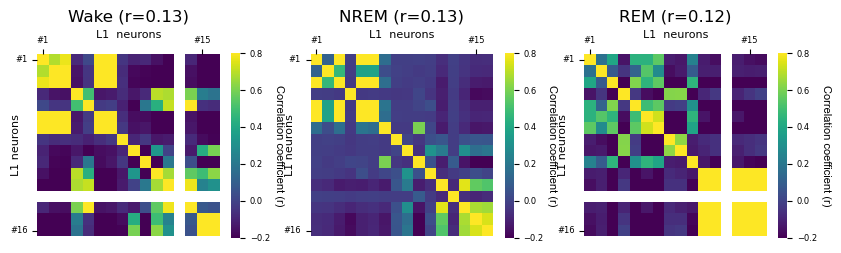

In [18]:
plt.close()

# Downscale Scoring to Calcium rec

SleepScoredTS_upscaledCa=SleepScoredTS_upscaled[round(StartTime*freqLFP):round((StartTime + (len(Calcium_sorted.T)/minian_freq))*freqLFP)]
SleepScoredTS_upscaledCa=SleepScoredTS_upscaled[round(StartTime*freqLFP):round((StartTime + (len(Calcium_sorted.T)/minian_freq))*freqLFP)]
indices = np.linspace(0, len(SleepScoredTS_upscaledCa) - 1, len(SleepScoredTS_upscaledCa))
new_indices = np.linspace(0, len(SleepScoredTS_upscaledCa) - 1, len(Calcium_sorted.T))
interpolated_func = interp1d(indices, SleepScoredTS_upscaledCa, kind='zero')
SleepScoredTS_upscaledCa2 = interpolated_func(new_indices)
SleepScoredTS_upscaledCa2 = np.round(SleepScoredTS_upscaledCa2 * 2) / 2


VMAX=.8
CaCorrWake=[]
CaCorrNREM=[]
CaCorrREM=[]
mapp= {0: 'NREM',1: 'REM', 1.5: 'Wake'}
for m in mapp:
    # Correlation between each neurons according to vigilance states 
    Bool = (SleepScoredTS_upscaledCa2[begCa:finCa] == m)
    Ac = np.array(A.copy())
    Ac = Ac[:, Bool]
    
    CaCorrVigStateMatrixName=f'CaCorr{mapp[m]}'
    CaCorrVigStateMatrix = locals()[CaCorrVigStateMatrixName]
    CaCorrMatrix=[]
    CaCorrMatrix = pd.DataFrame(columns=[i for i in range(len(A))], index=[i for i in range(len(A))])

    for unit in range(len(A)): 
        Carray_unit =Ac[unit,:]
        for unit2 in range(len(A)): 
            Carray_unit2 =Ac[unit2,:]
            indexMapp = unit
            indexMapp2 = unit2   
            corr_matrix = np.corrcoef(Carray_unit.astype(float), Carray_unit2.astype(float))                             
            CaCorrMatrix[indexMapp][indexMapp2]={1: 0.99999, -1: -0.99999}.get(np.round(corr_matrix[0, 1],5), np.round(corr_matrix[0, 1],5))
    CaCorrVigStateMatrix.append(CaCorrMatrix)
    
fig, axes = plt.subplots(1, 3, figsize=(10, 4))


CaCorrMatrix=pd.DataFrame(np.mean(CaCorrWake, axis=0))
df = CaCorrMatrix.apply(pd.to_numeric, errors='coerce')
ax = sns.heatmap(df, ax=axes[0], square=True, vmin=-.2 , vmax=VMAX , cmap='viridis',
                                  cbar_kws={'shrink': 0.6, 'aspect': 20})
# Set only the first and last ticks for x and y axes
# Get the number of ticks
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticks([x_ticks[0], x_ticks[-1]])
ax.set_yticks([y_ticks[0], y_ticks[-1]])

# Optionally, set the labels for these ticks if needed
ax.set_xticklabels([f'#{int(x_ticks[0])+1}', f'#{int(x_ticks[-1])+1}'],size=6)
ax.set_yticklabels([f'#{int(y_ticks[0])+1}', f'#{int(y_ticks[-1])+1}'],size=6)

# Optionally, add labels for the axes if needed
ax.set_xlabel('L2/3  neurons', labelpad=-2,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_xlabel('L1  neurons', labelpad=-2,size=8)
ax.set_ylabel('L2/3 neurons', labelpad=-8,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_ylabel('L1 neurons', labelpad=-8,size=8)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust the font size here
cbar.set_label('Correlation coefficient (r)', fontsize=8, font='Arial', rotation=-90, labelpad=10)
ax.xaxis.set_ticks_position('top')  # Move ticks to the top
ax.xaxis.set_label_position('top')  # Move label to the top
axes[0].set_title(f'Wake (r={(np.round(np.nanmean(CaCorrWake),2))})', fontsize=12)



CaCorrMatrix=pd.DataFrame(np.mean(CaCorrNREM, axis=0))
df = CaCorrMatrix.apply(pd.to_numeric, errors='coerce')
ax = sns.heatmap(df, ax=axes[1], square=True, vmin=-.2 , vmax=VMAX , cmap='viridis',
                                  cbar_kws={'shrink': 0.6, 'aspect': 20})
# Set only the first and last ticks for x and y axes
# Get the number of ticks
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticks([x_ticks[0], x_ticks[-1]])
ax.set_yticks([y_ticks[0], y_ticks[-1]])

# Optionally, set the labels for these ticks if needed
ax.set_xticklabels([f'#{int(x_ticks[0])+1}', f'#{int(x_ticks[-1])+1}'],size=6)
ax.set_yticklabels([f'#{int(y_ticks[0])+1}', f'#{int(y_ticks[-1])+1}'],size=6)

# Optionally, add labels for the axes if needed
ax.set_xlabel('L2/3  neurons', labelpad=-2,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_xlabel('L1  neurons', labelpad=-2,size=8)
ax.set_ylabel('L2/3 neurons', labelpad=-8,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_ylabel('L1 neurons', labelpad=-8,size=8)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust the font size here
cbar.set_label('Correlation coefficient (r)', fontsize=8, font='Arial', rotation=-90, labelpad=10)
ax.xaxis.set_ticks_position('top')  # Move ticks to the top
ax.xaxis.set_label_position('top')  # Move label to the top
axes[1].set_title(f'NREM (r={(np.round(np.nanmean(CaCorrNREM),2))})', fontsize=12)



CaCorrMatrix=pd.DataFrame(np.mean(CaCorrREM, axis=0))
df = CaCorrMatrix.apply(pd.to_numeric, errors='coerce')
ax = sns.heatmap(df, ax=axes[2], square=True, vmin=-.2 , vmax=VMAX , cmap='viridis',
                                  cbar_kws={'shrink': 0.6, 'aspect': 20})
# Set only the first and last ticks for x and y axes
# Get the number of ticks
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticks([x_ticks[0], x_ticks[-1]])
ax.set_yticks([y_ticks[0], y_ticks[-1]])

# Optionally, set the labels for these ticks if needed
ax.set_xticklabels([f'#{int(x_ticks[0])+1}', f'#{int(x_ticks[-1])+1}'],size=6)
ax.set_yticklabels([f'#{int(y_ticks[0])+1}', f'#{int(y_ticks[-1])+1}'],size=6)

# Optionally, add labels for the axes if needed
ax.set_xlabel('L2/3  neurons', labelpad=-2,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_xlabel('L1  neurons', labelpad=-2,size=8)
ax.set_ylabel('L2/3 neurons', labelpad=-8,size=8) if sum([i in dpath for i in MiceListL2]) else ax.set_ylabel('L1 neurons', labelpad=-8,size=8)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust the font size here
cbar.set_label('Correlation coefficient (r)', fontsize=8, font='Arial', rotation=-90, labelpad=10)
ax.xaxis.set_ticks_position('top')  # Move ticks to the top
ax.xaxis.set_label_position('top')  # Move label to the top
axes[2].set_title(f'REM (r={np.round(np.nanmean(CaCorrREM),2)})', fontsize=12)
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_3VigSt_{beg}to{fin}s_2heatmap.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

### Save Extract of Raw Data

In [135]:
from scipy.stats import zscore

CA1t=CA1[round(StartTime*freqLFP):round((StartTime + (len(Calcium_sorted.T)/minian_freq))*freqLFP)]
PFCt=PFC[round(StartTime*freqLFP):round((StartTime + (len(Calcium_sorted.T)/minian_freq))*freqLFP)]
S1t=S1[round(StartTime*freqLFP):round((StartTime + (len(Calcium_sorted.T)/minian_freq))*freqLFP)]
EMGt=EMG[round(StartTime*freqLFP):round((StartTime + (len(Calcium_sorted.T)/minian_freq))*freqLFP)]

proj_ThetaCWT=filterLFP(CA1,5,9)
proj_Beta1CWT=filterLFP(PFC,10,18)
proj_Beta2CWT=filterLFP(S1,10,18)
proj_DeltaCWT=filterLFP(PFC,1,4)

S1extract=(S1[round(beg*freqLFP):round(fin*freqLFP)])
BetaS1extract=(proj_Beta2CWT[round(beg*freqLFP):round(fin*freqLFP)])
DeltaCWTextract=(proj_DeltaCWT[round(beg*freqLFP):round(fin*freqLFP)])
PFCextract=(PFC[round(beg*freqLFP):round(fin*freqLFP)])
BetaPFCextract=(proj_Beta1CWT[round(beg*freqLFP):round(fin*freqLFP)])
CA1extract=(CA1[round(beg*freqLFP):round(fin*freqLFP)])
Thetaextract=(proj_ThetaCWT[round(beg*freqLFP):round(fin*freqLFP)])
EMGextract=(EMG[round(beg*freqLFP):round(fin*freqLFP)])
HypnoExtract=SleepScoredTS_upscaled[round(beg*freqLFP):round(fin*freqLFP)]

from scipy.ndimage import uniform_filter1d

window_size = 10
S1extractDS=S1extract[::100]
BetaS1extractDS=BetaS1extract[::100]
BetaS1extractDSw = uniform_filter1d(BetaS1extractDS, size=window_size, mode='nearest')
DeltaCWTextractDS=DeltaCWTextract[::100]
DeltaCWTextractDSw = uniform_filter1d(DeltaCWTextractDS, size=window_size, mode='nearest')
PFCextractDS=PFCextract[::100]
BetaPFCextractDS=BetaPFCextract[::100]
BetaPFCextractDSw = uniform_filter1d(BetaPFCextractDS, size=window_size, mode='nearest')
CA1extractDS=CA1extract[::100]
ThetaextractDS=Thetaextract[::100]
ThetaextractDSw = uniform_filter1d(ThetaextractDS, size=window_size, mode='nearest')

EMGextractDS=EMGextract[::100]
HypnoExtractDS=HypnoExtract[::100]

#Extract=pd.DataFrame({'S1': S1extract,'filtS1': BetaS1extract,  'PFC': PFCextract, 'filtPFC': BetaPFCextract, 'CA1':CA1extract,'filtCA1': Thetaextract,  'EMG':EMGextract, 'Hypno': HypnoExtract})
#ExtractDS=pd.DataFrame({'S1': S1extractDS, 'filtS1': BetaS1extractDSw, 'filtDelta': DeltaCWTextractDSw, 'PFC': PFCextractDS, 'filtPFC': BetaPFCextractDSw, 'CA1':CA1extractDS,'filtCA1': ThetaextractDSw,  'EMG':EMGextractDS, 'Hypno': HypnoExtractDS})

#CaExtract=zscore(upscaled_Calcium[int(beg/minian_freq*sample_rate):int(fin/minian_freq*sample_rate)]) #DOUBT ON CA_UPSCALED
#CaExtractDS=CaExtract[::100]

UnitName=[f'Unit #{i}' for i in range(len(Calcium))]
#Ca=pd.DataFrame(CaExtract, columns=UnitName)
#CaDSo=pd.DataFrame(CaExtractDS, columns=Calcium.index)
#CaDS = CaDSo*2 + [10 * i for i in range(1, len(CaDSo.columns) + 1)]

#Sum=pd.concat([Extract,Ca], axis=1)
#SumDS=pd.concat([ExtractDS,CaDS], axis=1)


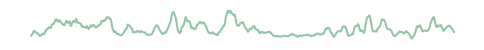

In [20]:
# Create a figure
plt.close()
plt.figure(figsize=(6, .4))

blend_factor = .5
hex_color = '#2E8B57'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot(zscore(BetaPFCextractDSw)/2, color=lighter_color_hex, linewidth=1.5)
plt.axis('off')  # Hides the axis lines and labels
plt.show()

In [ ]:
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_PFCraw&filtLFPs_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

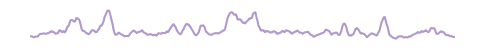

In [21]:
# Create a figure
plt.close()
plt.figure(figsize=(6, .4))

blend_factor = .5
hex_color = '#663399'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot(zscore(BetaS1extractDSw)/2, color=lighter_color_hex, linewidth=1.5)
plt.axis('off')  # Hides the axis lines and labels
plt.show()

In [ ]:
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_PFCraw&filtLFPs_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

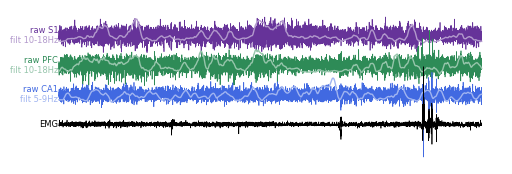

In [22]:
# Create a figure
plt.close()
plt.figure(figsize=(6, 2))

blend_factor = .5
hex_color = '#663399'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot(zscore(S1extractDS)/2, color='rebeccapurple', linewidth=.5)
plt.plot(zscore(BetaS1extractDSw)/2, color=lighter_color_hex, linewidth=1)
plt.text(-10, np.mean(zscore(S1extractDS)/2)+.5, 'raw S1', color='rebeccapurple', 
        ha='right', va='center', fontsize=6)  
plt.text(-10, np.mean(zscore(S1extractDS)/2)-.5, 'filt 10-18Hz', color=lighter_color_hex, 
        ha='right', va='center', fontsize=6) 

hex_color = '#2E8B57'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot(zscore(PFCextractDS)/2-3, color='seagreen', linewidth=.5)
plt.plot(zscore(BetaPFCextractDSw)/2-3, color=lighter_color_hex, linewidth=1)
plt.text(-10, np.mean(zscore(PFCextractDS)/2-3)+.5, 'raw PFC', color='seagreen', 
        ha='right', va='center', fontsize=6)  
plt.text(-10, np.mean(zscore(PFCextractDS)/2-3)-.5, 'filt 10-18Hz', color=lighter_color_hex, 
        ha='right', va='center', fontsize=6) 


hex_color = '#4169E1'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot(zscore(CA1extractDS)/2.5-6, color='royalblue', linewidth=.5)
plt.plot(zscore(ThetaextractDSw)/2.5-6, color=lighter_color_hex, linewidth=1)
plt.text(-10, np.mean(zscore(CA1extractDS)/2.5-6)+.5, 'raw CA1', color='royalblue', 
        ha='right', va='center', fontsize=6)  
plt.text(-10, np.mean(zscore(CA1extractDS)/2.5-6)-.5, 'filt 5-9Hz', color=lighter_color_hex, 
        ha='right', va='center', fontsize=6) 


plt.plot(zscore(EMGextractDS)/5-9, color='black', linewidth=.5)
plt.axis('off')  # Hides the axis lines and labels
plt.text(-10, np.mean(zscore(EMGextractDS)/5-9), 'EMG', color='black', 
        ha='right', va='center', fontsize=6)  

plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_AllLFPs_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


In [27]:
%matplotlib widget

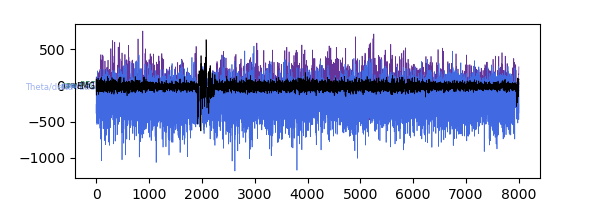

In [178]:
# Create a figure
plt.close()
plt.figure(figsize=(6, 2))

blend_factor = .5
hex_color = '#663399'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot((S1extractDS), color='rebeccapurple', linewidth=.5)
plt.text(-10, np.mean(zscore(S1extractDS))+.5, 'raw S1', color='rebeccapurple', 
        ha='right', va='center', fontsize=6)  

hex_color = '#2E8B57'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot((PFCextractDS)-6, color='seagreen', linewidth=.5)
plt.text(-10, np.mean(zscore(PFCextractDS)-6)+.5, 'raw PFC', color='seagreen', 
        ha='right', va='center', fontsize=6)  


hex_color = '#4169E1'
rgb_color = mcolors.hex2color(hex_color)
lighter_color = (1 - blend_factor) * np.array(rgb_color) + blend_factor * np.array([1, 1, 1])
lighter_color_hex = mcolors.to_hex(lighter_color)

plt.plot((CA1extractDS)-12, color='royalblue', linewidth=.5)
plt.text(-10, np.mean(zscore(CA1extractDS)-12)+.5, 'raw CA1', color='royalblue', 
        ha='right', va='center', fontsize=6)  


plt.plot(zscore(((ThetaextractDSw)+2)/((DeltaCWTextractDSw)+2)) -16, color=lighter_color_hex, linewidth=1)
plt.text(-10, np.mean(zscore(EMGextractDS)-16), 'Theta/delta ratio', color=lighter_color_hex, 
        ha='right', va='center', fontsize=6)  

plt.plot((EMGextractDS)-20, color='black', linewidth=.5)
#plt.axis('off')  # Hides the axis lines and labels
plt.text(-10, np.mean(zscore(EMGextractDS)-20), 'EMG', color='black', 
        ha='right', va='center', fontsize=6)  
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_AllLFPs_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


In [ ]:
filenameOut=f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_{beg}to{fin}s.xlsx'
writer=pd.ExcelWriter(filenameOut)
SumDS.to_excel(writer, sheet_name='All')
HypnoExtractDS=pd.DataFrame(HypnoExtractDS[::10])
HypnoExtractDS.to_excel(writer, sheet_name='DownSample10times')
writer.close()

In [ ]:
ExtractDS=pd.DataFrame({'Hypno': SleepScoredTS_upscaledCa2, 'GreenDotsOK12': Calcium_sorted.loc['GreenDotsOK12'], 
                        'GreenDotsOK11': Calcium_sorted.loc['GreenDotsOK11'], 'GreenDotsOK37': Calcium_sorted.loc['GreenDotsOK37'],
                          'GreenDotsOK9': Calcium_sorted.loc['GreenDotsOK9'], 'GreenDotsOK1':Calcium_sorted.loc['GreenDotsOK1'],
                          'GreenDotsOK10': Calcium_sorted.loc['GreenDotsOK10'],  'GreenDotsOK21':Calcium_sorted.loc['GreenDotsOK21']})


ExtractDSe=ExtractDS[beg:fin]
filenameOut=f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_RawTraces{int(beg/minian_freq)}to{int(fin/minian_freq)}s.xlsx'
ExtractDSe.to_excel(filenameOut)